#Norfolk & Waveney ICS prescribing data

Use this tool to pull raw data

In [ ]:
#@title Click the ▶ button to start
!pip install requests pandas tqdm openpyxl  &> /dev/null

# Import required modules
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime, timedelta
from google.colab import files
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import queue
import threading
import time
import os
import base64

def fetch_data_with_retry(resource_id, offset, limit=1000, retries=3):
    base_url = f"https://opendata.nhsbsa.net/api/3/action/datastore_search?offset={offset}&q=%7B%22ICB_CODE%22%3A%22QMM%3A%2A%22%7D&resource_id={resource_id}&limit={limit}"
    while retries > 0:
        try:
            response = requests.get(base_url)
            if response.status_code == 200:
                data = response.json()
                records = data['result']['records']
                return records
            elif response.status_code in {502, 500}:
                time.sleep(5)
                retries -= 1
            else:
                return []
        except requests.RequestException:
            return []
    return []

def fetch_records_for_range(resource_id, offset_queue, record_batches, limit, stop_event):
    while not offset_queue.empty() and not stop_event.is_set():
        offset = offset_queue.get()
        records = fetch_data_with_retry(resource_id, offset, limit)
        if not records:
            stop_event.set()  # Stop signal for all workers if no records are returned
        else:
            record_batches.append(records)
        offset_queue.task_done()
        clear_output(wait=True)  # Clear the output before printing
        print(f"\r{len(record_batches)*1000} rows of data pulled", end="")

def create_dataframe_from_batches_concurrently(record_batches):
    def create_dataframe_from_batch(batch):
        # Define the column order
        column_order = [
            'YEAR_MONTH', 'ICB_CODE', 'ICB_NAME', 'PCO_CODE', 'PCO_NAME',
            'REGIONAL_OFFICE_CODE', 'REGIONAL_OFFICE_NAME', 'PRACTICE_CODE',
            'PRACTICE_NAME', 'ADDRESS_1', 'ADDRESS_2', 'ADDRESS_3', 'ADDRESS_4',
            'POSTCODE', 'BNF_CHAPTER_PLUS_CODE', 'BNF_CHEMICAL_SUBSTANCE',
            'CHEMICAL_SUBSTANCE_BNF_DESCR', 'BNF_CODE', 'BNF_DESCRIPTION',
            'QUANTITY', 'ITEMS', 'TOTAL_QUANTITY', 'ADQUSAGE', 'NIC',
            'ACTUAL_COST', 'UNIDENTIFIED'
        ]
        df = pd.DataFrame(batch)
        df = df[column_order]
        return df

    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(create_dataframe_from_batch, batch) for batch in record_batches]
        dataframes = [future.result() for future in as_completed(futures)]

    return pd.concat(dataframes, ignore_index=True)

def get_all_data_concurrently(resource_id, limit=1000):
    record_batches = []
    offsets_to_fetch = queue.Queue()
    stop_event = threading.Event()  # Stop signal for all workers

    # Prepopulate the offsets from 0 to 1,000,000 in steps of 1,000
    for offset in range(0, 10000, limit):
        offsets_to_fetch.put(offset)

    print("Starting data fetch...")

    # Use ThreadPoolExecutor to fetch offsets concurrently
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = []
        for _ in range(16):
            future = executor.submit(fetch_records_for_range, resource_id, offsets_to_fetch, record_batches, limit, stop_event)
            futures.append(future)
        for future in as_completed(futures):
            future.result()

    print("\nData fetch completed. Converting to dataframes...")

    # Create DataFrame from batches concurrently
    df = create_dataframe_from_batches_concurrently(record_batches)

    print("Dataframes created. Merging and formatting data...")
    return df

def save_dataframe_to_csv(df, file_path):
    df.to_csv(file_path, index=False)


def main(selected_year, selected_month, num_months):
    # Calculate the starting and ending year_month values
    current_year_month = selected_year * 100 + selected_month
    start_year_month = current_year_month

    # Ensure the output directory exists
    output_directory = "Dispensing Data"
    os.makedirs(output_directory, exist_ok=True)

    all_data = pd.DataFrame()

    for _ in range(num_months):
        resource_id = f"EPD_{current_year_month}"

        df = get_all_data_concurrently(resource_id)

        print("Formatting completed")

        # Append the DataFrame to the all_data DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)
        if num_months > 1:
          # Decrement the year_month to get the previous month
          year = current_year_month // 100
          month = current_year_month % 100
          if month == 1:
              year -= 1
              month = 12
          else:
              month -= 1
          current_year_month = year * 100 + month


    if num_months > 1:
      # Create the output file name based on the start and end year_month
      end_year_month = current_year_month
      file_name = f"{start_year_month} to {end_year_month} - N&WICS Prescribing Data.csv"
    else:
      file_name = f"{start_year_month} - N&WICS Prescribing Data.csv"
    file_path = os.path.join(output_directory, file_name)

    # Save the combined DataFrame to a CSV file
    save_dataframe_to_csv(all_data, file_path)

    print(f"\rData has been fetched, click the following button to download to your PC. Alternatively, for larger files (or previous reports run in this session), see info below.")
    button = widgets.Button(description="Download File")

    def on_button_click_download(b):
      display(files.download(file_path))

    button.on_click(on_button_click_download)
    display(button)




    #download_button = widgets.Button(description="Download CSV")
    #download_button.on_click(lambda b: download_csv(file_path))
    #display(download_button)


# Calculate the default year and month (current date minus two months)
current_date = datetime.now()
default_date = current_date - timedelta(days=60)
default_year = default_date.year
default_month = default_date.month
style = {'description_width': '100px'}

# Widgets for user input
year_input = widgets.BoundedIntText(
    value=default_year,
    min=2022,
    max=default_year,
    step=1,
    description='Year:',
    disabled=False,
    style=style
)

month_input = widgets.Dropdown(
    options=[('Jan', 1), ('Feb', 2), ('Mar', 3), ('Apr', 4), ('May', 5), ('Jun', 6),
         ('Jul', 7), ('Aug', 8), ('Sep', 9), ('Oct', 10), ('Nov', 11), ('Dec', 12)],
    value=default_month,
    description='Month:',
    disabled=False,
    style=style
)

num_months_input = widgets.BoundedIntText(
    value=1,
    min=1,
    max=24,
    step=1,
    description='Months of data:',
    disabled=False,
    style=style
)


display(year_input, month_input, num_months_input)

# Button to confirm input
confirm_button = widgets.Button(
    description='Confirm',
    disabled=False,
    button_style='success',
    tooltip='Click to confirm your choices',
    icon='check'
)

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        global selected_year, selected_month, num_months
        selected_year = year_input.value
        selected_month = month_input.value
        num_months = num_months_input.value
        print(f"Year: {selected_year}, Month: {selected_month}, Number of Previous Months: {num_months}")
        main(selected_year, selected_month, num_months)


confirm_button.on_click(on_button_click)

display(confirm_button, output)


##Downloading reports

It's generally quicker to download the files by:

1.   Clicking the file explorer in the left hand bar
2.   Opening "Dispensing data" folder
3.   Selecting "Download" in the menu for the required file


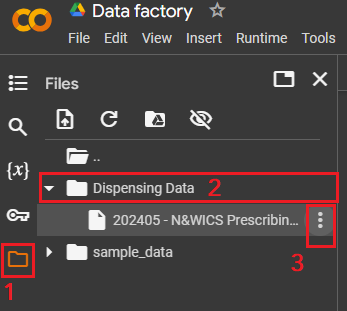

